In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
import scipy.stats as stats
import re


from scipy.stats import chi2_contingency
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, auc, classification_report, fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer


from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import kagglehub
import tqdm as notebook_tqdm




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\beert\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Data Analyst Jobs dataset
path = kagglehub.dataset_download("andrewmvd/data-analyst-jobs")
print("Path to dataset files:", path)
df = pd.read_csv(path + '\DataAnalyst.csv')

Path to dataset files: C:\Users\beert\.cache\kagglehub\datasets\andrewmvd\data-analyst-jobs\versions\1


## 2. Preprocessing

Primer eliminarem la variable Unnamed perquè és un identificador que resulta redundant, ja que Python ja assigna un índex a cada dada del dataset.

In [4]:
df.drop(columns=["Unnamed: 0"], inplace=True)

A continuació convertirem les variables categòriques a numèriques tractant alhora tots els nans

Conversió de Salary Estimate a numèric

In [5]:
def clean_salary(text):
    # Extrae todos los números del texto, en miles (K)
    numbers = re.findall(r'(\d+)', text)
    
    if len(numbers) >= 2:
        low = int(numbers[0]) * 1000
        high = int(numbers[1]) * 1000
        avg = (low + high)/2
        return low, high, avg
    else:
        return None, None, None
  
df["min_salary"], df["max_salary"], df["avg_salary"] = zip(*df["Salary Estimate"].apply(clean_salary))
df[["min_salary", "max_salary", "avg_salary"]].head()

,min_salary,max_salary,avg_salary
0,37000.0,66000.0,51500.0
1,37000.0,66000.0,51500.0
2,37000.0,66000.0,51500.0
3,37000.0,66000.0,51500.0
4,37000.0,66000.0,51500.0


In [6]:
print("Nuls a avg salary", df['avg_salary'].isna().sum())
print("Nuls a min salary", df['min_salary'].isna().sum())
print("Nuls a max salary", df['max_salary'].isna().sum())

Nuls a avg salary 1
Nuls a min salary 1
Nuls a max salary 1


Hi ha un sol nul a cada columna. Mirem si existeix ja una entrada anterior d'aquella empresa i imputem pel seu valor de salari. Com que és un valor que no té sentit que canvii entre diferents entrades té sentit imputar per aquest ja que eliminarem els nuls sense falsejar dades.

In [7]:
def impute_by_company(df, col):
    for idx, row in df[df[col].isna()].iterrows():
        company = row["Company Name"]
        
        # Buscar altres files de la mateixa empresa amb el valor definit
        candidates = df[(df["Company Name"] == company) & (~df[col].isna())]
        
        if len(candidates) > 0:
            # Copiem el primer valor disponible
            df.at[idx, col] = candidates.iloc[0][col]
    
    return df

df = impute_by_company(df, "min_salary")
df = impute_by_company(df, "max_salary")
df = impute_by_company(df, "avg_salary")

print("Nuls a avg salary", df['avg_salary'].isna().sum())
print("Nuls a min salary", df['min_salary'].isna().sum())
print("Nuls a max salary", df['max_salary'].isna().sum())

Nuls a avg salary 0
Nuls a min salary 0
Nuls a max salary 0


Conversió de Size a numeric. 

Les dades estan en la forma "201 to 500 employees" o "100000+ employees". Les convertim a un nombre mig si es troba en un rang de valors.

In [8]:
def parse_size(size):
    if size in [None, '-1', 'Unknown / Non-Applicable']:
        # Posem null si no es coneix la mida
        return None 
    if '+' in size:
        return float(size.replace('+ employees', '').strip())
    if 'to' in size:
        low, high = size.replace('employees', '').split('to')
        return int((float(low) + float(high)) / 2)
    return None

df['Size mean'] = df['Size'].apply(parse_size)
df['Size mean']

0         350.0
1       10000.0
2        3000.0
3         350.0
4         750.0
         ...   
2248      125.0
2249    10000.0
2250        NaN
2251      350.0
2252    10000.0
Name: Size mean, Length: 2253, dtype: float64

In [9]:
df['Size mean'] = df['Size mean'].fillna(df['Size mean'].median())


In [10]:
df['Size mean'].isna().sum()

0

Transformar el Revenue en valor numèric.

Les dades apareixen en la forma: "$100 to $500 million (USD)". Les convertim en un valor mig.

In [11]:
def parse_revenue(rev):
        if rev in ['Unknown / Non-Applicable', '-1', None]:
            return None
        
        rev = rev.replace('(USD)', '').replace('$', '').strip()

        # Caso "X to Y million" o "billion"
        if 'to' in rev:
            low, high = rev.split('to')
            low = low.strip()
            high = high.strip()

            # Identificar unidad
            if 'million' in high:
                mul = 1_000_000
            elif 'billion' in high:
                mul = 1_000_000_000
            else:
                return None

            low_val = float(low.replace('million', '').replace('billion', '').strip()) * mul
            high_val = float(high.replace('million', '').replace('billion', '').strip()) * mul

            return (low_val + high_val) / 2
        
        return None

df['Revenue mean'] = df['Revenue'].apply(parse_revenue)
df['Revenue mean']

0       3.000000e+08
1       3.500000e+09
2                NaN
3       7.500000e+07
4       3.000000e+08
            ...     
2248             NaN
2249             NaN
2250             NaN
2251    3.750000e+07
2252    3.500000e+09
Name: Revenue mean, Length: 2253, dtype: float64

In [12]:
df['Revenue mean'].isna().sum()

1060

Quan una variable té tants NaNs, el seu valor informatiu és molt baix, però el fet que no hi hagi informació potser és informatiu en si mateix. Moltes empreses petites no publiquen el seu revenue, mentre que les grans sí.

Això correlaciona amb:
- grandària de l'empresa
- estabilitat
- possiblement nivell salarial

Per tant, aquesta columna no s’ha d’imputar amb la mediana, perquè hi ha massa NaNs i imputar amb la mateixa mediana els faria semblants a les grans empreses.


crearem feature booleana per veure si lempresa dona informacio pel revenue. I imputarem els nans amb valor neutre 0

In [13]:
df['Has_revenue_info'] = df['Revenue mean'].notna().astype(int)
df['Revenue mean'] = df['Revenue mean'].fillna(0)
df['Revenue mean'].isna().sum()

0

Transformar l'any de fundacio de l'empresa en "l'edat" que té l'empresa. empreses més establertes solen pagar més i tenir salaris més estables

Si no sabem l'any de fundació, el valor serà NULL

In [14]:
df['Company Age'] = df['Founded'].apply(lambda x: 2025 - x if (pd.notna(x) and x != -1) else None)
df[["Company Age"]]

,Company Age
0,64.0
1,132.0
2,22.0
3,23.0
4,16.0
...,...
2248,NaN
2249,90.0
2250,NaN
2251,41.0


In [15]:
df["Company Age"].isna().sum()

660

In [16]:
# omplim aquelles company age conegudes en una altra entrada del dataset

df['Company Age'] = df.groupby('Company Name')['Company Age'].transform(
    lambda col: col.fillna(col.dropna().median()) if col.notna().any() else col
)

Busquem correlacio de company age amb les altres variables del dataset i mirem si podem imputar els nans faltants amb la mitjana del seu grup

In [17]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriu de correlació
corr_matrix = numeric_df.corr()

# Correlacions específiques amb Company Age
corr_with_age = corr_matrix['Company Age'].sort_values(ascending=False)

print("Correlació amb Company Age")
print(corr_with_age)

Correlació amb Company Age
Company Age     1.000000
Size mean       0.581145
Revenue mean   -0.010405
min_salary     -0.082539
Rating         -0.082853
avg_salary     -0.095607
max_salary     -0.098921
Founded        -0.541488
Name: Company Age, dtype: float64


<Figure size 1000x600 with 0 Axes>

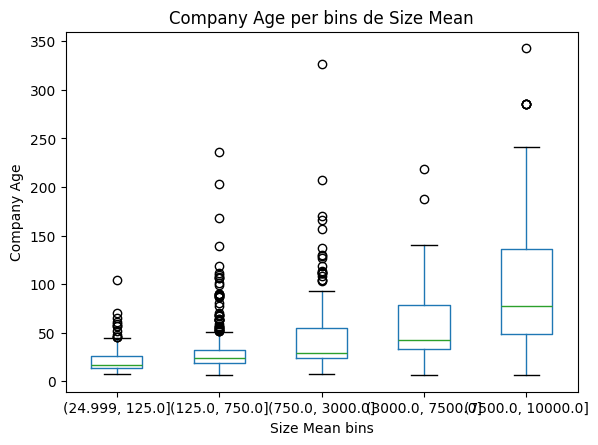

In [18]:
# Crear bins automàtics per Size mean
df['Size Bin'] = pd.qcut(df['Size mean'], q=6, duplicates='drop')

plt.figure(figsize=(10, 6))
df.boxplot(column='Company Age', by='Size Bin', grid=False)
plt.title("Company Age per bins de Size Mean")
plt.suptitle("")
plt.xlabel("Size Mean bins")
plt.ylabel("Company Age")
plt.show()


Podem observar com existeix clara relació entre les empreses grans (dentre 3000 i 10000 empleats) i l'edat mitjana que és més alta que per les empreses petites. 

Observem que hi ha certa dispersió però les medianes es veuen com són progressives entre tots els quantils de manera que els outliers que observem no afecten gaire a la mitjana que és el que utilitzarem doncs per imputar.

In [19]:
# Mediana d'edat per bin
median_age_by_bin = df.groupby('Size Bin')['Company Age'].median()

# Funció d'imputació
def impute_age_by_bin(row):
    if pd.isna(row['Company Age']):
        return median_age_by_bin[row['Size Bin']]
    return row['Company Age']

# Aplicar imputació
df['Company Age'] = df.apply(impute_age_by_bin, axis=1)

# Eliminar columna auxiliar
df.drop(columns=['Size Bin'], inplace=True)


C:\Users\beert\AppData\Local\Temp\ipykernel_12480\91822285.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_age_by_bin = df.groupby('Size Bin')['Company Age'].median()


In [20]:
df["Company Age"].isna().sum()

0

Ara eliminem les variables categòriques d'abans de la conversió.

In [21]:
df.drop(columns=["Salary Estimate", "Revenue", "Size", "Founded"], inplace=True)

**Selecció de variables**

Un cop tranformat el Sou estimat a numèric, analitzer les correlacions de les dades. El dataset té molts atributs categòrics que tenen molts valors, per tant, seria util podre fer selecció de variables en aquest punt basant-nos en la relacio que tenen amb el sou.

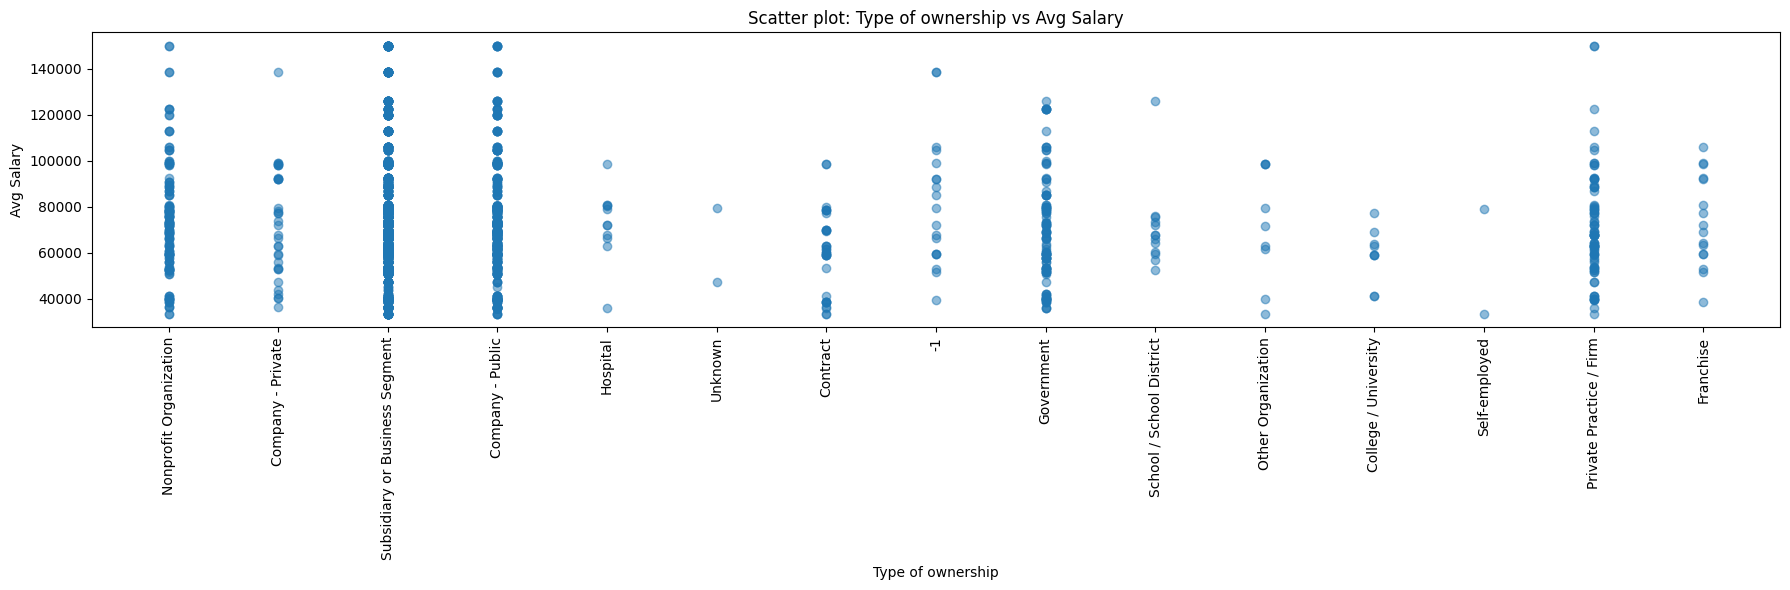

In [22]:
plt.figure(figsize=(18, 6))

# Codificar sectores numéricamente solo para poder graficar
df["Type of ownership code"] = df["Type of ownership"].astype("category").cat.codes

plt.scatter(df["Type of ownership code"], df["avg_salary"], alpha=0.5)

plt.xticks(
    ticks=range(len(df["Type of ownership"].unique())), 
    labels=df["Type of ownership"].unique(), 
    rotation=90
)

plt.title("Scatter plot: Type of ownership vs Avg Salary")
plt.xlabel("Type of ownership")
plt.ylabel("Avg Salary")
plt.tight_layout()
plt.show()


A primera vista, no podem establir si el Type of Ownership és una variable que afecta al sou. Hi ha tipus que tenen molta variabilitat del sou i altres que tenen variabilitat més baixa i sous també més baixos.

Per veure numèricament si el Type of Ownership afecta al sou mig (avg_salary), fem un ANOVA per comprovar si hi ha diferències significatives entre sectors i calculem el R² per mesurar quina part de la variabilitat salarial s’explica pel tipus d'empresa.

El ANOVA (Anàlisi de la Variança) serveix per comprovar si hi ha diferències estadísticament significatives entre els salaris mitjans dels sectors. El p-value ens indica si podem rebutjar la hipòtesi nul·la que afirma que tots els sectors tenen el mateix salari mitjà. Per poder rebutjar aquesta hipòtesi, el p-value hauria de ser < 0,05.

R² explicat pel sector, mesura la proporció de la variabilitat total dels salaris que es pot atribuir a la diferència entre sectors. Un valor de R² superior a 0,05 indicaria que aquesta variable és rellevant per explicar les diferències de salari.

In [23]:
df_clean = df.dropna(subset=["avg_salary", "Type of ownership"]).copy()

# Construim grups de sectors eliminant els NaN
groups = []
valid_sectors = []

for o in df_clean["Type of ownership"].unique():
    # Saltar no vàlids
    if o == "-1" or o is None or o == "Unknown" or o == "Other Organization":
        continue

    g = df_clean.loc[df_clean["Type of ownership"] == o, "avg_salary"]

    # ANOVA necesita mínim 2 oper grup
    if len(g) >= 2:
        groups.append(g)
        valid_sectors.append(o)

# --- ANOVA ---
print("=== ANOVA ===")
f_stat, p_value = stats.f_oneway(*groups)
print(f"P-value: {p_value}")

# --- R2 EXPLICADA PEL SECTOR ---
overall_mean = df_clean["avg_salary"].mean()

# SSB – Between-group variability
ss_between = sum([
    len(df_clean[df_clean["Type of ownership"] == s]) * 
    (df_clean[df_clean["Type of ownership"] == s]["avg_salary"].mean() - overall_mean)**2
    for s in valid_sectors
])

# SSW – Within-group variability
ss_within = sum([
    ((df_clean[df_clean["Type of ownership"] == s]["avg_salary"] - 
      df_clean[df_clean["Type of ownership"] == s]["avg_salary"].mean())**2).sum()
    for s in valid_sectors
])

r2 = ss_between / (ss_between + ss_within)

print("\n=== R² explicada pel sector ===")
print(f"R²: {r2:.4f}")



=== ANOVA ===
P-value: 0.04640969543096092

=== R² explicada pel sector ===
R²: 0.0097


Té un efecte estadísticament detectable (p-valor < 0,05), però gairebé no aporta informació per predir el salari (R2 < 0,05).

Agrupar-la podria simplificar el model, però no aportaria gaire poder explicatiu. De moment la deixem per no treure massa informació. Si després d'aquest preprocessing encara tenim moltes dimensions, tornarem a avaluar si eliminar aquesta variable.

Ara veiem un altre exemple amb la variable Industry

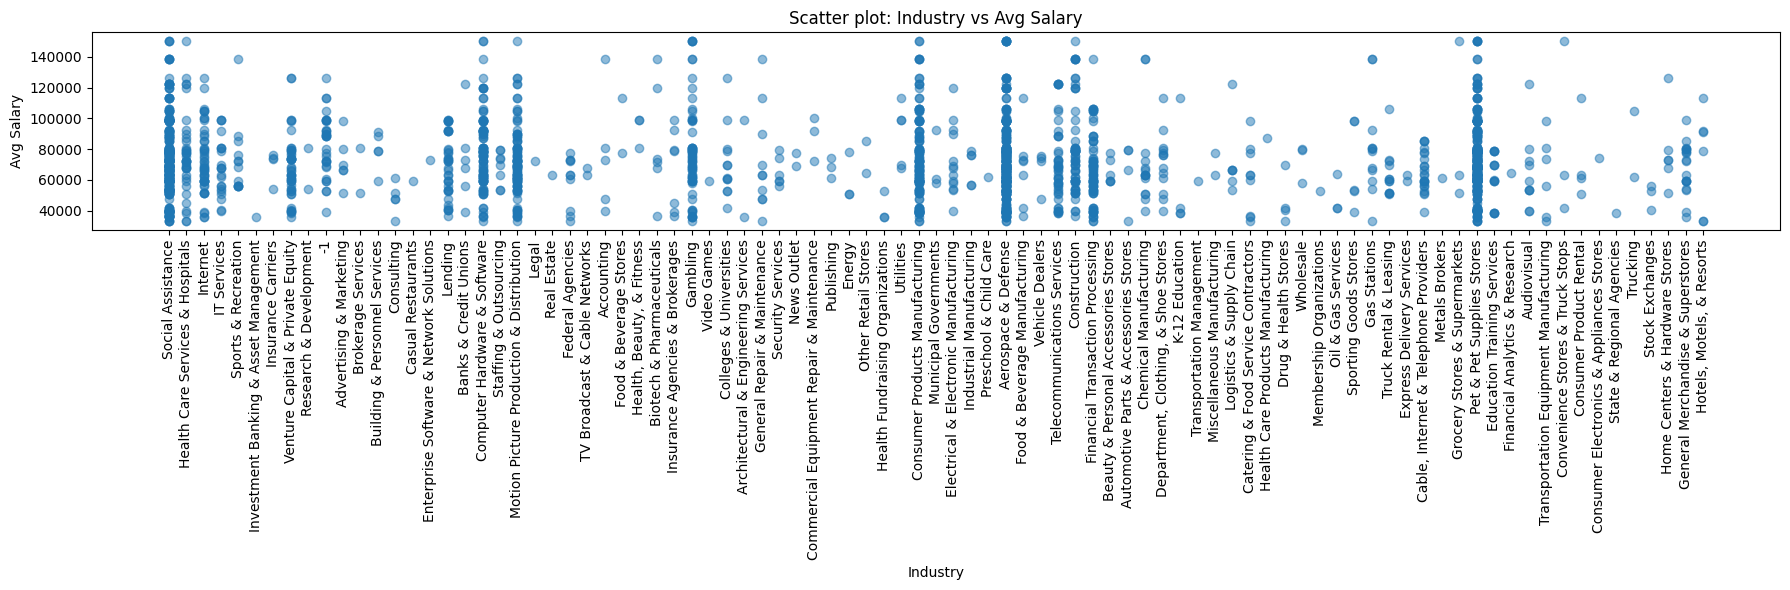

In [24]:
plt.figure(figsize=(18, 6))

# Codificar sectores numéricamente solo para poder graficar
df["Industry_code"] = df["Industry"].astype("category").cat.codes

plt.scatter(df["Industry_code"], df["avg_salary"], alpha=0.5)

plt.xticks(
    ticks=range(len(df["Industry"].unique())), 
    labels=df["Industry"].unique(), 
    rotation=90
)

plt.title("Scatter plot: Industry vs Avg Salary")
plt.xlabel("Industry")
plt.ylabel("Avg Salary")
plt.tight_layout()
plt.show()



In [25]:
df_clean = df.dropna(subset=["avg_salary", "Industry"]).copy()

# Construim grups de sectors eliminant els NaN
groups = []
valid_sectors = []

for i in df_clean["Industry"].unique():
    # Saltar no vàlids
    if i == "-1" or i is None:
        continue

    g = df_clean.loc[df_clean["Industry"] == i, "avg_salary"]

    # ANOVA necesita mínim 2 oper grup
    if len(g) >= 2:
        groups.append(g)
        valid_sectors.append(i)

# --- ANOVA ---
print("=== ANOVA ===")
f_stat, p_value = stats.f_oneway(*groups)
print(f"P-value: {p_value}")

# --- R2 EXPLICADA PEL SECTOR ---
overall_mean = df_clean["avg_salary"].mean()

# SSB – Between-group variability
ss_between = sum([
    len(df_clean[df_clean["Industry"] == s]) * 
    (df_clean[df_clean["Industry"] == s]["avg_salary"].mean() - overall_mean)**2
    for s in valid_sectors
])

# SSW – Within-group variability
ss_within = sum([
    ((df_clean[df_clean["Industry"] == s]["avg_salary"] - 
      df_clean[df_clean["Industry"] == s]["avg_salary"].mean())**2).sum()
    for s in valid_sectors
])

r2 = ss_between / (ss_between + ss_within)

print("\n=== R² explicada pel sector ===")
print(f"R²: {r2:.4f}")



=== ANOVA ===
P-value: 0.07605502499040666

=== R² explicada pel sector ===
R²: 0.0480


veiem que no tenim un p-value estadísticament significatiu i una R^2 poc explicativa. No obstant això es podria deure a que tenim moltes categories d'industry i aquestes tenen poques mostres. Agruparem primer per categories i després recalcularem per si cal eliminar la variable. 

In [26]:
counts = df['Industry'].value_counts().head(50) # tail(50)

# Mostrar les categories i la seva quantitat
print(counts)

Industry
-1                                           353
IT Services                                  325
Staffing & Outsourcing                       323
Health Care Services & Hospitals             151
Computer Hardware & Software                 111
Consulting                                   111
Investment Banking & Asset Management         78
Enterprise Software & Network Solutions       69
Internet                                      65
Advertising & Marketing                       51
Banks & Credit Unions                         51
Insurance Carriers                            47
Colleges & Universities                       40
Accounting                                    39
Biotech & Pharmaceuticals                     33
Social Assistance                             23
Aerospace & Defense                           22
Video Games                                   20
Lending                                       15
State & Regional Agencies                     15
Architectur

In [27]:
def map_industry(industry):
    if industry in ['IT Services', 'Computer Hardware & Software', 'Enterprise Software & Network Solutions', 'Internet', 'Telecommunications Services', 'Venture Capital & Private Equity']:
        return 'IT & Software'
    elif industry in ['Consulting', 'Investment Banking & Asset Management', 'Financial Transaction Processing', 'Brokerage Services', 'Financial Analytics & Research', 'Banks & Credit Unions', 'Insurance Carriers', 'Insurance Agencies & Brokerages', 'Stock Exchanges']:
        return 'Consulting & Finance'
    elif industry in ['Health Care Services & Hospitals', 'Biotech & Pharmaceuticals', 'Health Care Products Manufacturing', 'Health, Beauty, & Fitness', 'Social Assistance', 'Health Fundraising Organizations']:
        return 'Health & Pharma'
    elif industry in ['Colleges & Universities', 'K-12 Education', 'Education Training Services', 'Preschool & Child Care']:
        return 'Education'
    elif industry in ['Industrial Manufacturing', 'Electrical & Electronic Manufacturing', 'Consumer Products Manufacturing', 'Miscellaneous Manufacturing', 'Chemical Manufacturing', 'Food & Beverage Manufacturing', 'Transportation Equipment Manufacturing']:
        return 'Manufacturing & Industrial'
    elif industry in ['Consumer Electronics & Appliances Stores', 'Department, Clothing, & Shoe Stores', 'Grocery Stores & Supermarkets', 'Food & Beverage Stores', 'Convenience Stores & Truck Stops', 'Vehicle Dealers', 'Pet & Pet Supplies Stores', 'Sporting Goods Stores', 'Home Centers & Hardware Stores', 'Other Retail Stores', 'Casual Restaurants', 'Cable, Internet & Telephone Providers']:
        return 'Retail & Consumer'
    elif industry in ['Architectural & Engineering Services', 'Construction', 'Commercial Equipment Repair & Maintenance', 'Building & Personnel Services', 'Logistics & Supply Chain']:
        return 'Construction & Engineering'
    elif industry in ['Advertising & Marketing', 'TV Broadcast & Cable Networks', 'Publishing', 'News Outlet', 'Motion Picture Production & Distribution', 'Audiovisual', 'Catering & Food Service Contractors']:
        return 'Media & Marketing'
    elif industry in ['Federal Agencies', 'State & Regional Agencies', 'Municipal Governments']:
        return 'Government & Public'
    elif industry in ['Energy', 'Oil & Gas Services', 'Utilities']:
        return 'Energy & Utilities'
    elif industry in ['Trucking', 'Transportation Management', 'Express Delivery Services', 'Truck Rental & Leasing']:
        return 'Transportation'
    else:
        return 'Other / Miscellaneous'


df['Industry_Group'] = df['Industry'].apply(map_industry)


print(df['Industry_Group'].value_counts())


Industry_Group
Other / Miscellaneous         837
IT & Software                 582
Consulting & Finance          310
Health & Pharma               228
Media & Marketing              75
Education                      52
Construction & Engineering     42
Retail & Consumer              36
Government & Public            36
Manufacturing & Industrial     35
Energy & Utilities             13
Transportation                  7
Name: count, dtype: int64


In [28]:
df_clean2 = df.dropna(subset=["avg_salary", "Industry_Group"]).copy()

# Construïm grups de salaris per sector
groups = []
valid_sectors = []

for sector in df_clean2["Industry_Group"].unique():
    if sector == "-1" or sector is None:
        continue

    # Agafem els valors numèrics de salaris, no la columna de text
    g = df_clean2.loc[df_clean2["Industry_Group"] == sector, "avg_salary"]

    # ANOVA necessita mínim 2 observacions
    if len(g) >= 2:
        groups.append(g)
        valid_sectors.append(sector)

# --- ANOVA ---
print("=== ANOVA ===")
f_stat, p_value = stats.f_oneway(*groups)
print(f"P-value: {p_value}")

# --- R² explicada pel sector ---
overall_mean = df_clean2["avg_salary"].mean()

# SSB – Between-group variability
ss_between = sum([
    len(df_clean2[df_clean2["Industry_Group"] == s]) * 
    (df_clean2[df_clean2["Industry_Group"] == s]["avg_salary"].mean() - overall_mean)**2
    for s in valid_sectors
])

# SSW – Within-group variability
ss_within = sum([
    ((df_clean2[df_clean2["Industry_Group"] == s]["avg_salary"] - 
      df_clean2[df_clean2["Industry_Group"] == s]["avg_salary"].mean())**2).sum()
    for s in valid_sectors
])

r2 = ss_between / (ss_between + ss_within)

print("\n=== R² explicada pel sector ===")
print(f"R²: {r2:.4f}")


=== ANOVA ===
P-value: 0.014783300583440968

=== R² explicada pel sector ===
R²: 0.0104


El sector té un efecte estadísticament significatiu sobre el salari però  és poc rellevant, perquè la quantitat de variància explicada és molt baixa (1.04%).

Per tant, és probable que incloure el sector no milloraria gaire el model i augmentaria molt la dimensionalitat del problema.


Per acabar, abans de concloure en la seva eliminació, agrupem les dues colunes estudiades per veure si combinades podrien ser prou explicaties com per mantenirles al model:

In [29]:
counts = df['Type of ownership'].value_counts().head(50) # tail(50)

# Mostrar les categories i la seva quantitat
print(counts)

Type of ownership
Company - Private                 1273
Company - Public                   452
-1                                 163
Nonprofit Organization             124
Subsidiary or Business Segment      89
Government                          37
College / University                34
Hospital                            19
Unknown                             16
Other Organization                  13
Contract                            11
School / School District             9
Private Practice / Firm              9
Self-employed                        2
Franchise                            2
Name: count, dtype: int64


In [30]:
# Simplificar Type of ownership
def map_ownership(x):
    if x in ["Company - Private"]:
        return "Private"
    elif x in ["Company - Public"]:
        return "Public"
    elif x in ["Government", "College / University", "Hospital", "School / School District", "Nonprofit Organization"]:
        return "Public/Nonprofit"
    else:
        return "Other"

df['Ownership_Group'] = df['Type of ownership'].apply(map_ownership)

# Exemple combinant amb Industry_Group
df['Industry_Ownership'] = df['Industry_Group'] + " | " + df['Ownership_Group']


counts = df['Industry_Ownership'].value_counts().head(50) # tail(50)

# Mostrar les categories i la seva quantitat
print(counts)

Industry_Ownership
Other / Miscellaneous | Private             453
IT & Software | Private                     446
Other / Miscellaneous | Other               235
Consulting & Finance | Private              152
Other / Miscellaneous | Public              132
Consulting & Finance | Public               115
IT & Software | Public                      114
Health & Pharma | Public/Nonprofit          105
Health & Pharma | Private                    77
Media & Marketing | Private                  46
Education | Public/Nonprofit                 44
Health & Pharma | Public                     32
Construction & Engineering | Private         32
Government & Public | Public/Nonprofit       29
Consulting & Finance | Public/Nonprofit      27
Retail & Consumer | Private                  23
Media & Marketing | Public                   21
IT & Software | Other                        21
Manufacturing & Industrial | Private         18
Other / Miscellaneous | Public/Nonprofit     17
Consulting & Finance 

In [31]:
# Map Industry a grups més grans
def map_industry_simple(x):
    if x in ["IT & Software", "Consulting & Finance"]:
        return "Tech_Finance"
    elif x in ["Health & Pharma", "Education", "Government & Public"]:
        return "Health_Education"
    elif x in ["Media & Marketing", "Retail & Consumer"]:
        return "Media_Retail"
    elif x in ["Manufacturing & Industrial", "Energy & Utilities", "Construction & Engineering", "Transportation"]:
        return "Industry_Energy_Construction"
    else:
        return "Other"

df['Industry_Simple'] = df['Industry_Group'].apply(map_industry_simple)

# Map Ownership a 3 grups
def map_ownership_simple(x):
    if x == "Private":
        return "Private"
    elif x == "Public/Nonprofit":
        return "Public/Nonprofit"
    else:
        return "Other"

df['Ownership_Simple'] = df['Ownership_Group'].apply(map_ownership_simple)

# Combinar
df['Industry_Ownership_Simple'] = df['Industry_Simple'] + " | " + df['Ownership_Simple']

# Veure resultats
print(df['Industry_Ownership_Simple'].value_counts())


Industry_Ownership_Simple
Tech_Finance | Private                    598
Other | Private                           453
Other | Other                             367
Tech_Finance | Other                      266
Health_Education | Public/Nonprofit       178
Health_Education | Private                 89
Media_Retail | Private                     69
Industry_Energy_Construction | Private     64
Health_Education | Other                   49
Media_Retail | Other                       42
Industry_Energy_Construction | Other       33
Tech_Finance | Public/Nonprofit            28
Other | Public/Nonprofit                   17
Name: count, dtype: int64


In [32]:
df_clean3 = df.dropna(subset=["avg_salary", "Industry_Ownership_Simple"]).copy()

# Construïm grups de salaris per sector
groups = []
valid_sectors = []

for sector in df_clean3["Industry_Ownership_Simple"].unique():
    if sector == "-1" or sector is None:
        continue

    # Agafem els valors numèrics de salaris, no la columna de text
    g = df_clean3.loc[df_clean3["Industry_Ownership_Simple"] == sector, "avg_salary"]

    # ANOVA necessita mínim 2 observacions
    if len(g) >= 2:
        groups.append(g)
        valid_sectors.append(sector)

# --- ANOVA ---
print("=== ANOVA ===")
f_stat, p_value = stats.f_oneway(*groups)
print(f"P-value: {p_value}")

# --- R² explicada pel sector ---
overall_mean = df_clean3["avg_salary"].mean()

# SSB – Between-group variability
ss_between = sum([
    len(df_clean3[df_clean3["Industry_Ownership_Simple"] == s]) * 
    (df_clean3[df_clean3["Industry_Ownership_Simple"] == s]["avg_salary"].mean() - overall_mean)**2
    for s in valid_sectors
])

# SSW – Within-group variability
ss_within = sum([
    ((df_clean3[df_clean3["Industry_Ownership_Simple"] == s]["avg_salary"] - 
      df_clean3[df_clean3["Industry_Ownership_Simple"] == s]["avg_salary"].mean())**2).sum()
    for s in valid_sectors
])

r2 = ss_between / (ss_between + ss_within)

print("\n=== R² explicada pel sector ===")
print(f"R²: {r2:.4f}")


=== ANOVA ===
P-value: 0.03573740762598493

=== R² explicada pel sector ===
R²: 0.0098


Veiem com tot i la significació estadística de p-value = 0.035 < 0.05, només un 1% de la variança del salary prové d'aquesta variale pe tant té un impacte pràctic molt baix.

In [33]:
# Esborrem les columnes auxiliars de les gràfiques
df.drop(columns=["Industry_code", "Type of ownership code"], inplace=True)

Per veure un resum general, fem un codi per fer aquest anàlisi

In [34]:
# Neteja de dades: eliminem files amb NaN en avg_salary
df_clean = df.dropna(subset=["avg_salary"]).copy()

cols = df_clean.columns.tolist()
cols.remove("avg_salary")
cols.remove("min_salary")
cols.remove("max_salary")

resultats = []

for col in cols:
    # Saltar si només té un valor únic
    if df_clean[col].nunique() <= 1:
        continue

    # Eliminem valors invàlids de la columna
    df_var = df_clean.loc[(df_clean[col].notna()) & (df_clean[col] != "-1")]

    # Construïm grups amb almenys 2 observacions
    groups = []
    valid_categories = []
    for cat in df_var[col].unique():
        g = df_var.loc[df_var[col] == cat, "avg_salary"]
        if len(g) >= 2:
            groups.append(g)
            valid_categories.append(cat)

    if len(groups) < 2:
        continue  # No podem fer ANOVA amb menys de 2 grups

    # --- ANOVA ---
    f_stat, p_value = stats.f_oneway(*groups)

    # --- R² ---
    overall_mean = df_var["avg_salary"].mean()
    ss_between = sum([
        len(df_var[df_var[col] == c]) * 
        (df_var[df_var[col] == c]["avg_salary"].mean() - overall_mean)**2
        for c in valid_categories
    ])
    ss_within = sum([
        ((df_var[df_var[col] == c]["avg_salary"] - 
          df_var[df_var[col] == c]["avg_salary"].mean())**2).sum()
        for c in valid_categories
    ])
    r2 = ss_between / (ss_between + ss_within) if (ss_between + ss_within) != 0 else 0

    # Decisió d'eliminació
    if p_value >= 0.05 and r2 < 0.05:
        decision = "Eliminar"
    elif p_value >= 0.05 or r2 < 0.05:
        decision = "Valorar"
    else:
        decision = "Mantenir"

    resultats.append({
        "Variable": col,
        "P-value": p_value,
        "R²": r2,
        "Decisió": decision
    })

# Convertim els resultats a DataFrame i ordenem per R² descendent
resultats_df = pd.DataFrame(resultats).sort_values("R²", ascending=False)
print(resultats_df)


                     Variable        P-value        R²   Decisió
8                 Competitors   1.184404e-06  0.475161  Mantenir
3                    Location  4.045954e-160  0.437282  Mantenir
2                Company Name   2.020643e-08  0.429445  Mantenir
4                Headquarters   3.375613e-22  0.254172  Mantenir
0                   Job Title   3.799080e-02  0.190404  Mantenir
12                Company Age   3.211914e-05  0.085950  Mantenir
6                    Industry   7.605502e-02  0.048048  Eliminar
1                      Rating   2.816807e-02  0.023834   Valorar
15         Industry_Ownership   6.694924e-02  0.020888  Eliminar
7                      Sector   1.151592e-02  0.020169   Valorar
13             Industry_Group   1.478330e-02  0.010432   Valorar
18  Industry_Ownership_Simple   3.573741e-02  0.009823   Valorar
5           Type of ownership   9.186736e-02  0.009627  Eliminar
10               Revenue mean   3.372236e-01  0.005003  Eliminar
14            Ownership_G

In [35]:
df.drop(columns=["Industry", "Type of ownership", "Ownership_Simple", "Industry_Ownership", "Industry_Simple"], inplace=True)
df_clean3.drop(columns=["Industry", "Type of ownership", "Ownership_Simple", "Industry_Ownership", "Industry_Simple", "Industry_code", "Type of ownership code"], inplace=True)


Les variables que ens ha arribat a conclusio d'eliminar/valorar, això no vol dir necessàriament que no tinguin cap rellevància, sinó que per si soles, en un ANOVA simple, no expliquen gaire del salari. És oribble que les variables tinguin interaccions amb altres variables així que abans d'eliminar-les les provarem en un model multivariable. 

In [36]:
df_model = df_clean3.copy()

# Variables a provar (les que ANOVA marca "Mantenir" o "Valorar")
vars_categoricals = [
    "Industry_Ownership_Simple", "Rating", "Sector", "Industry_Group", "Ownership_Group"
]

vars_continuous = [
    "Revenue mean", "Size mean", "Company Age", "Has_revenue_info"
]

# Omplim NaN per variables contínues (opcional: amb mitjana)
df_model[vars_continuous] = df_model[vars_continuous].fillna(df_model[vars_continuous].mean())

# Eliminem files amb NaN en variables categòriques
df_model = df_model.dropna(subset=vars_categoricals + ["avg_salary"])

X = df_model[vars_categoricals + vars_continuous]
y = df_model["avg_salary"]


In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), vars_categoricals),
        ('num', StandardScaler(), vars_continuous)
    ]
)

# Pipeline amb regressió lineal
#pipeline = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('regressor', LinearRegression())
#])

# Pipeline amb Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=500, random_state=42, n_jobs=-1
    ))
])

# Dividim train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# Entrenar
pipeline.fit(X_train, y_train)

# Predir
y_pred = pipeline.predict(X_test)

# R² sobre test set
r2 = r2_score(y_test, y_pred)
print(f"R² multivariable: {r2:.4f}")


R² multivariable: -0.2059


Provant models multiavriables tant de regressió lineal com de random forest obtenim uns R2 negatius tal que aquests factors no aporten informació predictiva rellevant ni tant sols combinades. per tant, eliminem les variables que segons anova podiem eliminar.

Ara decidim sobre les variables que segons anova calia valorar. teniem les seguents dades:
| Variable                  | P-value | R²    
| ------------------------- | ------- | ------
| Industry_Group            | 0.0148  | 0.0104
| Industry_Ownership_Simple | 0.0357  | 0.0098
| Sector                    | 0.0115  | 0.0202
| Rating                    | 0.0282  | 0.0238

tenim un R^2 molt baix tal que tenim molt poca explicació de la variança del salari i p-values estadisticament significatives però practicament sense efecte. Comparant amb altres variables com competitors o location el seu efecte es marginal. Decidim mantenir sector i rating que tenen efectes lleugerament més importants i eliminem industry i industry_ownership evitant així dimensionalitat extra tenint un model més net i estable.

In [39]:
df.drop(columns=["Industry_Ownership_Simple", "Revenue mean", "Size mean", "Has_revenue_info",  "Ownership_Group"], inplace= True)
# no elimine de moment industy group perque la farem servir mes endavant


**Conversio daltres variables categoriques**

Ara tenint només les variables que tenen una relació significant amb la variable objectiu, és el moment de convertir les variables categòriques amb one-hot-encoding per poder entrenar correctament el nostre model.

Variable Job Title

In [40]:
# Nombre de valors únics
num_unics = df['Job Title'].nunique()
print("Nombre de valors únics a Job Title:", num_unics)

# Nombre de valors totals
num_totals = df['Job Title'].shape[0]

# Nombre de valors repetits
num_repetits = num_totals - num_unics
print("Nombre de valors repetits a Job Title:", num_repetits)

Nombre de valors únics a Job Title: 1272
Nombre de valors repetits a Job Title: 981


Hi ha massa valors unics per fer one hot ncoding aixi que agruparem per categories i despres assignarem.

Usant el wordcloud vist a l'apartat de EDA prenem:

In [41]:
def clean_title(title):
    title = title.lower()
    title = re.sub(r'[^a-z0-9\s]', '', title)  # eliminar símbols
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df['clean_title'] = df['Job Title'].apply(clean_title)

In [42]:
def categorize_job_title_refined_v2(title):
    t = title.lower()

    # Senioritat
    if any(x in t for x in ["senior", "sr ", "sr.", "lead", "principal"]):
        seniority = "senior"
    elif any(x in t for x in ["junior", "jr ", "jr.", "entry", "intern"]):
        seniority = "junior"
    else:
        seniority = "mid"

    # Rol
    if "data analyst" in t or "report" in t:
        role = "data_analyst"
    elif "business analyst" in t or "financial" in t:
        role = "business_analyst"
    elif "engineer" in t or "etl" in t or "warehouse" in t:
        role = "data_engineer"
    elif "scientist" in t:
        role = "data_scientist"
    elif any(x in t for x in [
        "quality", "governance", "compliance", 
        "security", "health", "research", "product"
    ]):
        role = "specialist"
    else:
        role = "other"

    return f"{seniority}_{role}"

df["JobTitle_grouped"] = df["clean_title"].apply(categorize_job_title_refined_v2)
print(df["JobTitle_grouped"].value_counts().head(30))

JobTitle_grouped
mid_data_analyst           1283
senior_data_analyst         358
mid_other                   208
mid_specialist               98
junior_data_analyst          81
senior_other                 72
mid_business_analyst         55
mid_data_engineer            30
senior_specialist            19
senior_business_analyst      19
junior_other                  8
senior_data_engineer          6
mid_data_scientist            6
senior_data_scientist         5
junior_business_analyst       2
junior_data_engineer          2
junior_specialist             1
Name: count, dtype: int64


In [43]:
# label encoding
le = LabelEncoder()
df["JobTitle_numeric"] = le.fit_transform(df["JobTitle_grouped"])

# Veure el mapping
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(mapping)


{'junior_business_analyst': 0, 'junior_data_analyst': 1, 'junior_data_engineer': 2, 'junior_other': 3, 'junior_specialist': 4, 'mid_business_analyst': 5, 'mid_data_analyst': 6, 'mid_data_engineer': 7, 'mid_data_scientist': 8, 'mid_other': 9, 'mid_specialist': 10, 'senior_business_analyst': 11, 'senior_data_analyst': 12, 'senior_data_engineer': 13, 'senior_data_scientist': 14, 'senior_other': 15, 'senior_specialist': 16}


In [44]:
df = df.drop(columns=["Job Title", "JobTitle_grouped", "clean_title"])

Variable Job Description

In [45]:
# Llista de "stop words" en angles
stop_words = stopwords.words('english')

# Funció per netejar el text
def clean_text(text):
    text = text.lower()  # Convertir a minúscules
    text = re.sub(r'\d+', '', text)  # Eliminar nombres
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signes de puntuació
    return text

# Aplicar neteja a les descripcions
df['cleaned_description'] = df['Job Description'].apply(clean_text)

# Vectorització del text
vectorizer = CountVectorizer(stop_words=stop_words, max_features=20)
X = vectorizer.fit_transform(df['cleaned_description'])

# Obtenir les paraules més freqüents
frequent_words = vectorizer.get_feature_names_out()

print(frequent_words)


['ability' 'analysis' 'analyst' 'analytics' 'business' 'data' 'experience'
 'information' 'job' 'knowledge' 'management' 'reporting' 'required'
 'requirements' 'skills' 'strong' 'support' 'team' 'work' 'years']


Veiem com algunes 'aquestes paraules més freqüents són molt generals d'una descripció de feina i segurament no tenen rellevància a l'hora de predir el sou així que anem a fer una selecció de quines paraules són clau per la predicció. 

In [46]:
# Crear columnes booleanes per cada paraula
for word in frequent_words:
    df[f'word_{word}'] = df['cleaned_description'].apply(lambda x: 1 if word in x else 0)

# ANOVA de cada paraula amb el salari
anova_results = []
for word in frequent_words:
    group_0 = df.loc[df[f'word_{word}'] == 0, 'avg_salary']
    group_1 = df.loc[df[f'word_{word}'] == 1, 'avg_salary']
    
    # Calculem ANOVA només si ambdós grups tenen almenys 2 observacions
    if len(group_0) >= 2 and len(group_1) >= 2:
        f_stat, p_value = stats.f_oneway(group_0, group_1)
        anova_results.append({'word': word, 'p_value': p_value})

anova_df = pd.DataFrame(anova_results).sort_values('p_value')
print(anova_df)

for word in frequent_words:
    df = df.drop(columns=[f"word_{word}"])



            word   p_value
13  requirements  0.000013
17          team  0.002149
11     reporting  0.002366
7    information  0.004009
10    management  0.004896
14        skills  0.042033
9      knowledge  0.061069
2        analyst  0.090698
1       analysis  0.118095
4       business  0.215197
0        ability  0.239616
5           data  0.422808
16       support  0.524155
8            job  0.532342
6     experience  0.608063
15        strong  0.770664
3      analytics  0.791995
18          work  0.871507
19         years  0.900690
12      required  0.962715


In [47]:
best_words = ['requirements', 'team', 'reporting', 'information', 'management', 'skills']

# Crear columnes booleanes per cada paraula clau
for word in best_words:
    df[f'contains_{word}'] = df['cleaned_description'].apply(lambda x: 1 if word in x else 0)

df.drop(columns=['cleaned_description'], inplace=True)

Variable Company Name

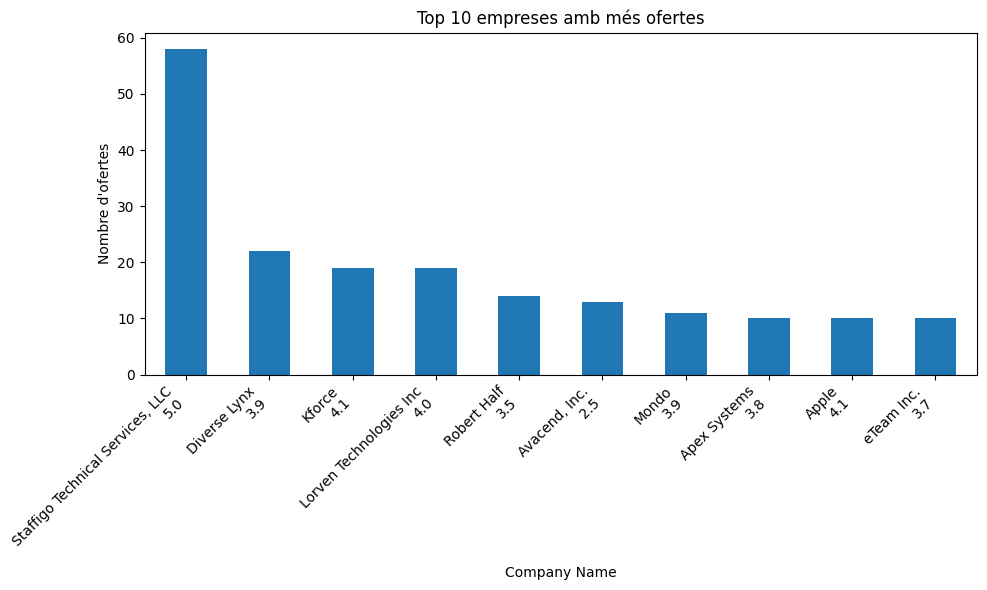

In [48]:
# Comptar ofertes per empresa
top_companies = df['Company Name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar')
plt.title("Top 10 empreses amb més ofertes")
plt.xlabel("Company Name")
plt.ylabel("Nombre d'ofertes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [49]:
# Comptar les ocurrències de cada empresa
company_counts = df['Company Name'].value_counts()

# Filtrar les empreses que apareixen només un cop
companies_one_time = company_counts[company_counts == 1]

# Comptar quantes empreses apareixen només un cop
num_companies_one_time = len(companies_one_time)

# Mostrar el resultat
print(f"Hi ha {num_companies_one_time} empreses que apareixen un únic cop.")

# Mostrar els resultats
print(company_counts)


Hi ha 1173 empreses que apareixen un únic cop.
Company Name
Staffigo Technical Services, LLC\n5.0    58
Diverse Lynx\n3.9                        22
Kforce\n4.1                              19
Lorven Technologies Inc\n4.0             19
Robert Half\n3.5                         14
                                         ..
Empire Today\n3.7                         1
Numerator\n3.9                            1
BDP International\n3.0                    1
Ferrara Candy Company\n3.5                1
SCL Health\n3.4                           1
Name: count, Length: 1513, dtype: int64


In [50]:
# tractem el nan
df['Company Name'] = df['Company Name'].fillna(df['Location'] + "Company")

El Company name es un string que com a tal no podem aprofitar per fer una codificació ja que hi ha moltes empreses amb una única entrada i no es troben patrons repetits que puguem usar per codificar i que no estiguin ja recollits en alguna altra ariable com sector. no obstant, com que hi ha empreses que tenen vàries entrades a la base de dades el que farem serà afegir una columna que compti el número d'ofertes d'aquella empresa. En general, una empresa amb moltes ofertes implicarà que és una empresa gran i que per tant pot ser que estigui relacionat amb el salari. 

In [51]:
df['Company Offers'] = df.groupby('Company Name')['Company Name'].transform('count')

**Competitors**:

Hem vist que és una variable categòrica de les que té més nuls. Imputar els seus valors no té sentit per un altre variable que no sigui  Unknown a més tenim molts valors 


In [52]:
# Comptar nombre d’entrades per cada categoria
counts = df['Competitors'].value_counts()
print("Nombre d’entrades per cada categoria:")
counts.head(50)


Nombre d’entrades per cada categoria:


Competitors
-1                                                           1732
Robert Half, Insight Global                                    14
Adecco, Manpower                                               14
Artech Information Systems, Mindlance, Tech Mahindra           10
Google, Microsoft, Samsung Electronics                         10
TEKsystems, Insight Global, Accenture                          10
Adecco, Kforce                                                  9
State Street, Northern Trust, BlackRock                         9
Accenture, CGI, Sopra Steria                                    7
Kforce, Insight Global, Volt Consulting Group                   7
Capgemini, Slalom, Accenture                                    6
Charles Schwab, Fidelity Investments, Edward Jones              5
Collabera, Artech Information Systems, TEKsystems               5
Adecco, ManpowerGroup, Allegis Corporation                      5
Experis                                                         

In [53]:
# Comptar quantes categories tenen només 1 entrada
unique_count = (counts == 1).sum()
print(f"\nNombre de categories amb només 1 entrada: {unique_count}")


Nombre de categories amb només 1 entrada: 193


In [54]:
# creem una variable que sigui el numero de competidors per quantificar el model
df['num_competitors'] = df['Competitors'].apply(
    lambda x: 0 if x == '-1' else len(x.split(','))
)

Location:

In [55]:
num_locations = df['Location'].nunique()
print(f"Nombre de locations diferents: {num_locations}")


location_counts = df['Location'].value_counts()
print("\nNombre d’entrades per location:")
print(location_counts.head(60))

Nombre de locations diferents: 253

Nombre d’entrades per location:
Location
New York, NY                       310
Chicago, IL                        130
San Francisco, CA                  119
Austin, TX                          81
Los Angeles, CA                     80
Charlotte, NC                       78
Houston, TX                         72
Dallas, TX                          66
San Diego, CA                       62
Philadelphia, PA                    56
Denver, CO                          47
San Antonio, TX                     45
San Jose, CA                        38
Phoenix, AZ                         35
Jersey City, NJ                     33
Tempe, AZ                           31
Seattle, WA                         30
Irving, TX                          29
Columbus, OH                        29
Plano, TX                           28
Santa Clara, CA                     22
Salt Lake City, UT                  22
El Segundo, CA                      19
Jacksonville, FL          

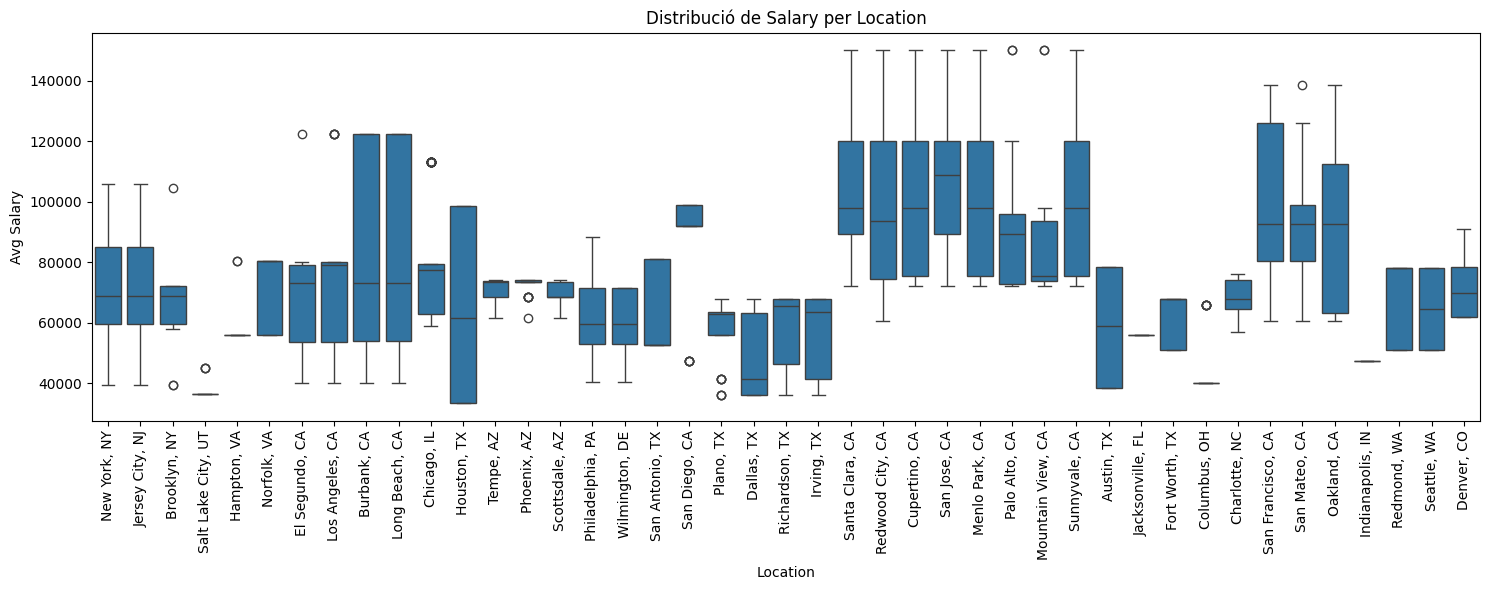

In [56]:
min_entries = 10
top_locations = location_counts[location_counts >= min_entries].index

plt.figure(figsize=(15,6))
sns.boxplot(x='Location', y='avg_salary', data=df[df['Location'].isin(top_locations)])
plt.xticks(rotation=90)
plt.title('Distribució de Salary per Location')
plt.ylabel('Avg Salary')
plt.xlabel('Location')
plt.tight_layout()
plt.show()

In [57]:
# Extreure l’estat
df['State'] = df['Location'].str.split(',').str[-1].str.strip()

# Llista d’estats únics
states = df['State'].dropna().unique()

# Guardarem els resultats
anova_results = []

for state in states:
    df_state = df[df['State'] == state]
    
    # Comprovem quantes ciutats hi ha i quantes observacions té cada una
    city_counts = df_state['Location'].value_counts()
    cities = city_counts[city_counts >= 2].index  # Només ciutats amb almenys 2 observacions
    
    if len(cities) < 2:
        continue  # No podem fer ANOVA amb menys de 2 grups
    
    # Crear grups per ANOVA
    groups = [df_state[df_state['Location'] == city]['avg_salary'] for city in cities]
    
    # ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    anova_results.append({
        'State': state,
        'Num_cities': len(cities),
        'Num_obs': len(df_state),
        'P_value': p_value
    })

anova_df = pd.DataFrame(anova_results).sort_values('P_value')

print(anova_df)


   State  Num_cities  Num_obs       P_value
5     FL           2       27  0.000000e+00
3     CA          47      626  1.923992e-21
7     TX          19      394  7.479566e-04
14    CO           9       96  1.335651e-02
8     AZ           7       97  1.660674e-02
1     NJ          16       86  4.469605e-02
6     IL           8      164  7.723031e-02
4     VA           5       48  1.196688e-01
9     PA          12      114  1.658998e-01
13    WA           7       54  5.291267e-01
10    OH           4       35  5.764219e-01
0     NY           6      345  6.140702e-01
11    NC           3       90  6.288995e-01
2     UT           3       33  8.040515e-01
12    IN           2       23           NaN


C:\Users\beert\AppData\Local\Temp\ipykernel_12480\3908128247.py:24: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = stats.f_oneway(*groups)
C:\Users\beert\AppData\Local\Temp\ipykernel_12480\3908128247.py:24: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = stats.f_oneway(*groups)


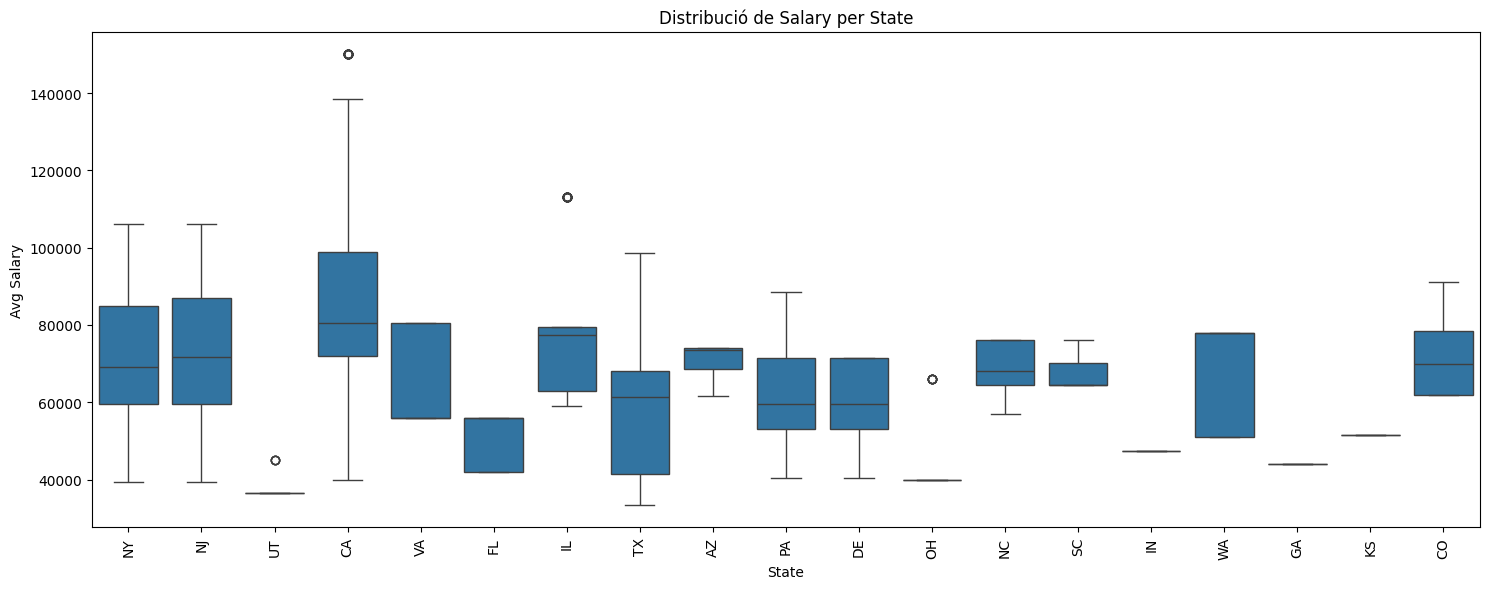

In [58]:
plt.figure(figsize=(15,6))
sns.boxplot(x='State', y='avg_salary', data=df)
plt.xticks(rotation=90)
plt.title('Distribució de Salary per State')
plt.ylabel('Avg Salary')
plt.xlabel('State')
plt.tight_layout()
plt.show()

In [59]:
def encode_location(row):
    loc = row['Location']
    state = row['State']
    
    # Combinar estats petits
    if state in ['UT','OH']:
        return 'UT_OH'
    elif state in ['IN','GA','KS']:
        return 'IN_GA_KS'
    elif state in ['DE', 'SC']:
        return 'DE_SC'
    
    # CA top 3 cities
    if state == 'CA':
        top_ca = ['San Francisco, CA', 'Los Angeles, CA', 'San Diego, CA']
        if loc in top_ca:
            return loc
        else:
            return 'Other_CA'
    
    # TX top 3 cities
    if state == 'TX':
        top_tx = ['Austin, TX', 'Houston, TX', 'Dallas, TX']
        if loc in top_tx:
            return loc
        else:
            return 'Other_TX'
    
    # CO: top 1 + Other_CO
    if state == 'CO':
        top_co = ['Denver, CO']
        if loc == top_co[0]:
            return loc
        else:
            return 'Other_CO'
    
    # AZ: top 1 + Other_AZ
    if state == 'AZ':
        top_az = ['Phoenix, AZ']
        if loc == top_az[0]:
            return loc
        else:
            return 'Other_AZ'
    
    # Altres estats amb p-value alt: només estat
    high_pvalue_states = ['IL','VA','PA','NY','NC','NJ','FL']
    if state in high_pvalue_states:
        return state
    
    # FL i NJ: mantenir top city i Other_<State>
    top_state_cities = {
        'FL': ['Jacksonville, FL'],
        'NJ': ['Jersey City, NJ'],
    }
    if state in top_state_cities:
        if loc in top_state_cities[state]:
            return loc
        else:
            return f'Other_{state}'
    
    # Per qualsevol altre cas, deixar estat
    return state

df['Location_final'] = df.apply(encode_location, axis=1)
print(df['Location_final'].value_counts())

Location_final
Other_CA             365
NY                   345
Other_TX             175
IL                   164
San Francisco, CA    119
PA                   114
NC                    90
NJ                    86
Austin, TX            81
Los Angeles, CA       80
Houston, TX           72
UT_OH                 68
Dallas, TX            66
Other_AZ              62
San Diego, CA         62
WA                    54
Other_CO              49
VA                    48
Denver, CO            47
Phoenix, AZ           35
IN_GA_KS              30
FL                    27
DE_SC                 14
Name: count, dtype: int64


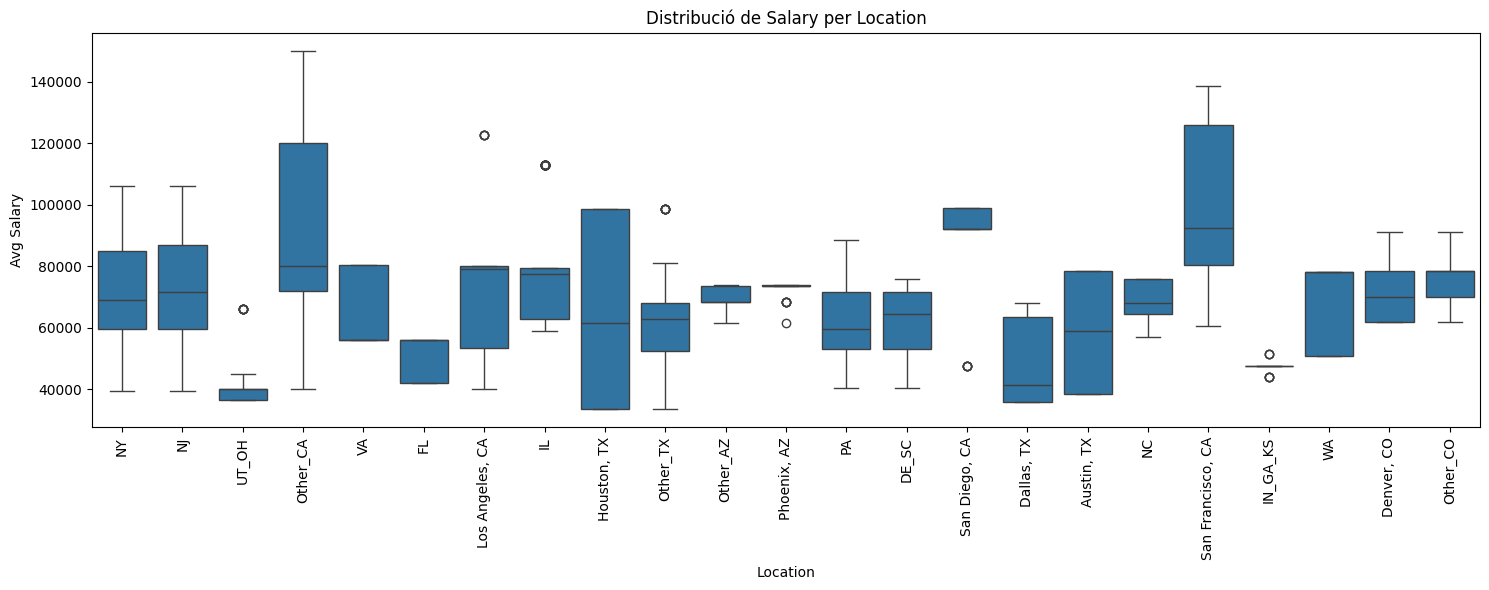

In [60]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Location_final', y='avg_salary', data=df)
plt.xticks(rotation=90)
plt.title('Distribució de Salary per Location')
plt.ylabel('Avg Salary')
plt.xlabel('Location')
plt.tight_layout()
plt.show()

veiem que per una mateixa ciutat es poden tenir mitjanes salarials molt diferent per tant agrupar per estat i fer nomes certes distincions de ciutats per alguns estats no ajuda gaire a predir el model. Per tant, agruparem la localització unicament per estat i a  mes aquells estats amb poques entrades i de mitjanes salarials diferents també els agruparem.

In [61]:
def encode_state(row):
    state = row['State']
    
    if state in ['UT','OH']:
        return 'UT_OH'
    elif state in ['IN','GA','KS']:
        return 'IN_GA_KS'
    elif state in ['DE', 'SC']:
        return 'DE_SC'
    return state

df['State_encoded'] = df.apply(encode_state, axis=1)
print(df['State_encoded'].value_counts())

State_encoded
CA          626
TX          394
NY          345
IL          164
PA          114
AZ           97
CO           96
NC           90
NJ           86
UT_OH        68
WA           54
VA           48
IN_GA_KS     30
FL           27
DE_SC        14
Name: count, dtype: int64


In [62]:
# Codificar a numèrica
le = LabelEncoder()
df['Location_num'] = le.fit_transform(df['State_encoded'])
df.drop(columns=['State_encoded', 'Location_final'], inplace=True)

Headquarters:

In [63]:
# hearquarters -> molta correlacio amb location aixi que mirem de distribuir des daqui.
coincidencia = (df['Location'] == df['Headquarters']).sum()
print("Coincidències Headquarters i Location:", coincidencia)

# Filtrar files on Headquarters i Location són diferents (i Headquarters no és NaN)
diff_hq_location = df[(df['Headquarters'] != '-1') & (df['Headquarters'] != df['Location'])]

# Guardar en una variable
comparativa_diff = diff_hq_location[['Headquarters', 'Location', 'Company Name']]

print(comparativa_diff)

Coincidències Headquarters i Location: 651
                Headquarters         Location  \
3                 McLean, VA     New York, NY   
5               Stamford, CT     New York, NY   
8     London, United Kingdom     New York, NY   
12                 Bronx, NY     New York, NY   
14               Phoenix, AZ  Jersey City, NJ   
...                      ...              ...   
2244          Alpharetta, GA       Denver, CO   
2245             Ashburn, VA   Centennial, CO   
2247              Newark, CA   Broomfield, CO   
2248          Alpharetta, GA       Denver, CO   
2251        West Chester, OH   Centennial, CO   

                            Company Name  
3                          Celerity\n4.1  
5                           Point72\n3.9  
8                              DMGT\n4.0  
12               Montefiore Medical\n3.7  
14                    Advisor Group\n3.4  
...                                  ...  
2244                  Avacend, Inc.\n2.5  
2245  Forfeiture Support

Hi ha 650 files on coincideix el Herdquarter i la Location pero hi ha 2251 files (no nules) on no coincideix (segurament per varies seus), mirem si es pot a partir del company name veure quines empreses tenen una sola seu i substituir aquelles

In [64]:
# Reemplaçar -1 per NaN
df['Headquarters'] = df['Headquarters'].replace('-1', pd.NA)

# Comptar quants Headquarters únics té cada companyia
hq_counts = df.groupby('Company Name')['Headquarters'].nunique(dropna=True).reset_index()
hq_counts.rename(columns={'Headquarters': 'hq_unique_count'}, inplace=True)

# Filtrar companyies amb un únic Headquarters conegut
companyies_segures = hq_counts[hq_counts['hq_unique_count'] == 1]['Company Name']
# Crear un diccionari Company Name -> Headquarters únic
hq_dict = df[df['Company Name'].isin(companyies_segures)].groupby('Company Name')['Headquarters'].first().to_dict()
# Imputar només les files segures amb Headquarters nul
df['Headquarters'] = df.apply(
    lambda row: hq_dict[row['Company Name']] if pd.isna(row['Headquarters']) and row['Company Name'] in hq_dict else row['Headquarters'],
    axis=1
)

# Comprovar quants nuls queden després de la imputació
print("Nuls a Headquarters després de la imputació:", df['Headquarters'].isna().sum())

Nuls a Headquarters després de la imputació: 171


Tenint en compte que la Location hem acabat agrupant-la segons el estat potser veiem que els headquarters no canvien gaire d'estat a la localització i podem atribuir-li al headquarter el valor del estat.

In [65]:
df['StateHeadquarters']= df['Headquarters'].str.split(',').str[-1].str.strip()

# Comptar coincidències d'estat entre Location i Headquarters
coincidencies_estat = (df['State'] == df['StateHeadquarters']).sum()
total_files = len(df)

print(f"Coincidències d'estat Location vs Headquarters: {coincidencies_estat} de {total_files} files")


Coincidències d'estat Location vs Headquarters: 949 de 2253 files


Veiem que hi ha mes coincidencies si només mirem el estat aixi que imputarem els nans per lestat i codifiquem per lestat igual que hem fet a Location

In [66]:
# Substituir NaN o '-1' per l'estat de Location
df['StateHeadquarters'] = df['StateHeadquarters'].replace(['-1', ''], pd.NA)
df['StateHeadquarters'] = df['StateHeadquarters'].fillna(df['State'])


print(df['StateHeadquarters'].value_counts().head(50))

StateHeadquarters
CA                512
NY                278
TX                204
IL                175
NJ                172
VA                106
PA                 95
FL                 61
MI                 51
GA                 48
NC                 47
WA                 43
MD                 41
AZ                 38
CO                 35
OH                 35
United Kingdom     29
India              27
MA                 24
MO                 20
TN                 16
UT                 14
Japan              14
Canada             13
France             12
IN                 11
CT                  9
DC                  9
SC                  7
Singapore           7
Switzerland         7
MN                  6
AL                  5
WI                  5
Germany             5
DE                  4
OK                  4
Australia           4
KS                  4
RI                  4
PR                  4
IA                  4
Ireland             3
OR                  3
NH            

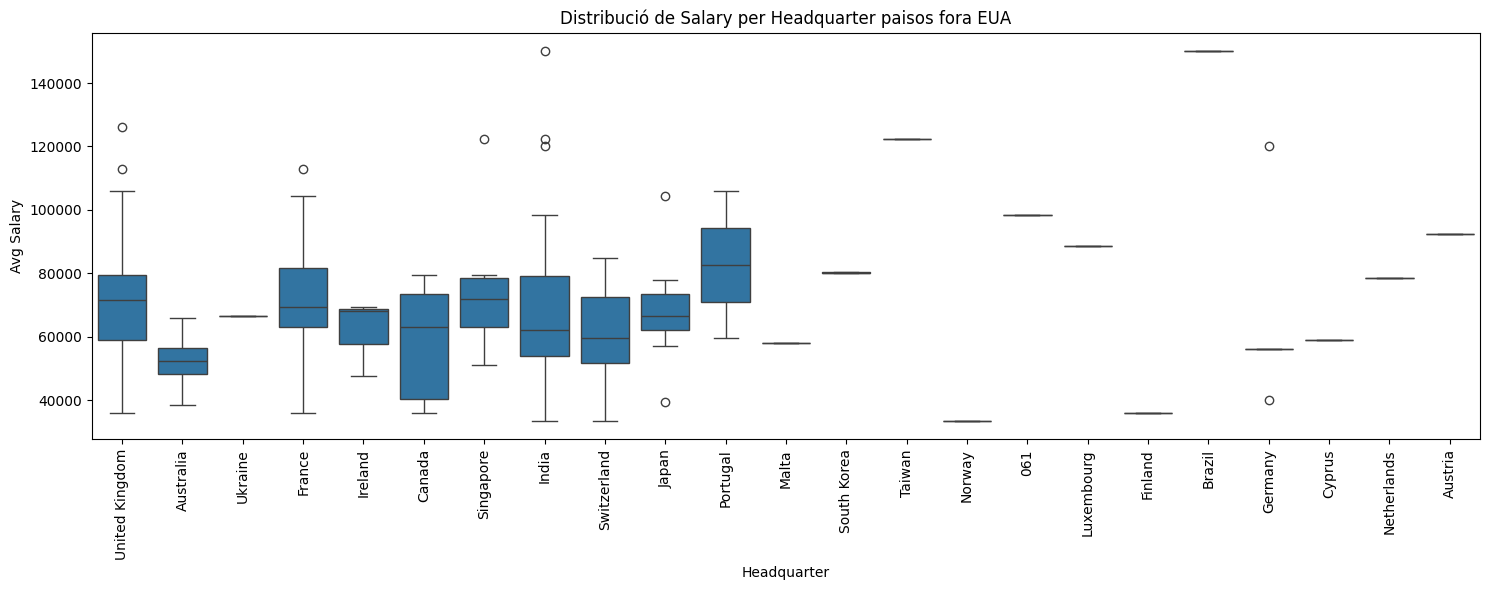

In [67]:
us_states = set([
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN',
    'IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV',
    'NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN',
    'TX','UT','VT','VA','WA','WV','WI','WY','DC','PR'
])

df['IsForeign'] = ~df['StateHeadquarters'].isin(us_states)
df_foreign = df[df['IsForeign']]

plt.figure(figsize=(15,6))
sns.boxplot(x='StateHeadquarters', y='avg_salary', data=df_foreign)
plt.xticks(rotation=90)
plt.title('Distribució de Salary per Headquarter paisos fora EUA')
plt.ylabel('Avg Salary')
plt.xlabel('Headquarter')
plt.tight_layout()
plt.show()

In [68]:
def map_region(hq):
    if hq in us_states:
        return "USA"
    europe = {'United Kingdom','France','Ireland','Switzerland','Germany','Portugal','Netherlands','Austria','Finland','Norway','Luxembourg','Cyprus','Ukraine','Malta'}
    asia = {'India','Japan','South Korea','Singapore','Taiwan'}
    oceania = {'Australia','New Zealand'}
    latin = {'Brazil'}
    if hq in europe:
        return "Europe"
    elif hq in asia:
        return "Asia"
    elif hq in oceania:
        return "Oceania"
    elif hq in latin:
        return "LatinAmerica"
    elif hq == "Canada":
        return "Canada"
    else:
        return "Other"

df['Headquarters Region'] = df['StateHeadquarters'].apply(map_region)


# Compute salary mean per region
region_salary_mean = df.groupby('Headquarters Region')['avg_salary'].mean()
# Map to a numerical column
df['Headquarters_num'] = df['Headquarters Region'].map(region_salary_mean)

region_summary = df.groupby('Headquarters Region')['Headquarters_num'].unique().reset_index()
region_summary

,Headquarters Region,Headquarters_num
0,Asia,[71852.94117647059]
1,Canada,[59730.769230769234]
2,Europe,[68552.23880597015]
3,LatinAmerica,[150000.0]
4,Oceania,[52375.0]
5,Other,[98500.0]
6,USA,[72309.54631379963]


In [69]:
df.drop(columns=['Headquarters Region', 'StateHeadquarters'], inplace=True)

Sector

In [70]:
num_sectors = df['Sector'].nunique()
print(f"Nombre de sectors diferents: {num_sectors}")


sectors_counts = df['Sector'].value_counts()
print("\nNombre d’entrades per sector:")
print(sectors_counts.head(60))

Nombre de sectors diferents: 25

Nombre d’entrades per sector:
Sector
Information Technology                570
Business Services                     524
-1                                    353
Finance                               169
Health Care                           151
Education                              52
Insurance                              51
Accounting & Legal                     43
Media                                  42
Manufacturing                          40
Retail                                 38
Government                             36
Biotech & Pharmaceuticals              33
Non-Profit                             26
Aerospace & Defense                    22
Transportation & Logistics             20
Construction, Repair & Maintenance     16
Consumer Services                      14
Oil, Gas, Energy & Utilities           13
Real Estate                            12
Telecommunications                     11
Restaurants, Bars & Food Services       8
Arts, 

In [71]:
df['Sector'] = df['Sector'].replace('-1', np.nan)
print(df['Sector'].isna().sum())


353


In [72]:
mode_sector_by_industry = df.groupby('Industry_Group')['Sector'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# imputem segons industria
def fill_sector(row):
    if pd.isna(row['Sector']):
        return mode_sector_by_industry.get(row['Industry_Group'])
    return row['Sector']

df['Sector'] = df.apply(fill_sector, axis=1)

In [73]:
num_sectors = df['Sector'].nunique()
print(f"Nombre de sectors diferents: {num_sectors}")


sectors_counts = df['Sector'].value_counts()
print("\nNombre d’entrades per sector:")
print(sectors_counts.head(60))

Nombre de sectors diferents: 24

Nombre d’entrades per sector:
Sector
Business Services                     877
Information Technology                570
Finance                               169
Health Care                           151
Education                              52
Insurance                              51
Accounting & Legal                     43
Media                                  42
Manufacturing                          40
Retail                                 38
Government                             36
Biotech & Pharmaceuticals              33
Non-Profit                             26
Aerospace & Defense                    22
Transportation & Logistics             20
Construction, Repair & Maintenance     16
Consumer Services                      14
Oil, Gas, Energy & Utilities           13
Real Estate                            12
Telecommunications                     11
Restaurants, Bars & Food Services       8
Arts, Entertainment & Recreation        7
Mining

In [74]:
mapping = {
    'Restaurants, Bars & Food Services': 'Consumer Services',
    'Arts, Entertainment & Recreation': 'Media',
    'Mining & Metals': 'Manufacturing',
    'Travel & Tourism': 'Consumer Services'
}

df['Sector_Grouped'] = df['Sector'].replace(mapping)

# Label Encoding
le = LabelEncoder()
df['Sector_num'] = le.fit_transform(df['Sector_Grouped'])

In [75]:
df.drop(columns=['Sector_Grouped'], inplace=True)

EasyApply:

In [76]:
num_applies = df['Easy Apply'].nunique()
print(f"Nombre de applies diferents: {num_applies}")


appliesn_counts = df['Easy Apply'].value_counts()
print("\nNombre d’entrades per location:")
print(appliesn_counts.head(60))

Nombre de applies diferents: 2

Nombre d’entrades per location:
Easy Apply
-1      2173
True      80
Name: count, dtype: int64


In [77]:
# Convertim -1 a False
df['Easy_Apply'] = df['Easy Apply'].map({'True': 1, '-1': 0})

# Comprovem
df['Easy_Apply'].value_counts()

df.drop(columns=['Easy Apply'], inplace=True)

Matriu de correlació:

In [78]:
final_model = df.drop(columns=['Job Description', 'Company Name', 'Competitors', 'Location', 'State', 'Headquarters', 'Sector', 'Industry_Group','IsForeign'])
final_model

,Rating,min_salary,max_salary,avg_salary,Company Age,JobTitle_numeric,contains_requirements,contains_team,contains_reporting,contains_information,contains_management,contains_skills,Company Offers,num_competitors,Location_num,Headquarters_num,Sector_num,Easy_Apply
0,3.2,37000.0,66000.0,51500.0,64.0,6,0,1,1,1,1,1,1,0,9,72309.546314,14,1
1,3.8,37000.0,66000.0,51500.0,132.0,6,0,1,1,1,1,1,1,0,9,72309.546314,9,0
2,3.4,37000.0,66000.0,51500.0,22.0,12,0,1,1,1,0,1,1,1,9,72309.546314,10,0
3,4.1,37000.0,66000.0,51500.0,23.0,6,1,1,0,1,1,1,1,0,9,72309.546314,10,0
4,3.9,37000.0,66000.0,51500.0,16.0,6,1,1,1,1,0,1,1,1,9,72309.546314,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,2.5,78000.0,104000.0,91000.0,17.0,10,0,0,0,0,0,1,13,0,2,72309.546314,3,0
2249,2.9,78000.0,104000.0,91000.0,90.0,12,1,1,1,1,1,1,1,3,2,72309.546314,3,0
2250,-1.0,78000.0,104000.0,91000.0,24.0,5,1,1,0,1,1,0,3,0,2,72309.546314,3,0
2251,3.1,78000.0,104000.0,91000.0,41.0,6,1,1,0,1,0,1,1,0,2,72309.546314,10,0


Comprovació Nans restants:

In [79]:
missing = final_model.isna().sum() # Valors nuls normals

special_missing = (final_model == -1).sum() # Valors amb -1 considerats com a nuls
special_missing += (final_model== "-1").sum()
special_missing += (final_model == -1.0).sum()

total_missing = missing.add(special_missing, fill_value=0)
total_missing = total_missing[total_missing > 0]
total_missing

Rating    544
dtype: int64

Imputarem els nuls de rating fent un model predictiu:

In [80]:
final_model['Rating'] = final_model['Rating'].replace(-1, np.nan)
train = final_model[final_model['Rating'].notna()]
test = final_model[final_model['Rating'].isna()]

X_train = train.drop('Rating', axis=1)
y_train = train['Rating']
X_test = test.drop('Rating', axis=1)

# Entrenem model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecim els nuls
final_model.loc[final_model['Rating'].isna(), 'Rating'] = model.predict(X_test)


In [81]:
missing = final_model.isna().sum() # Valors nuls normals

special_missing = (final_model == -1).sum() # Valors amb -1 considerats com a nuls
special_missing += (final_model== "-1").sum()
special_missing += (final_model == -1.0).sum()

total_missing = missing.add(special_missing, fill_value=0)
total_missing = total_missing[total_missing > 0]
total_missing

Series([], dtype: int64)

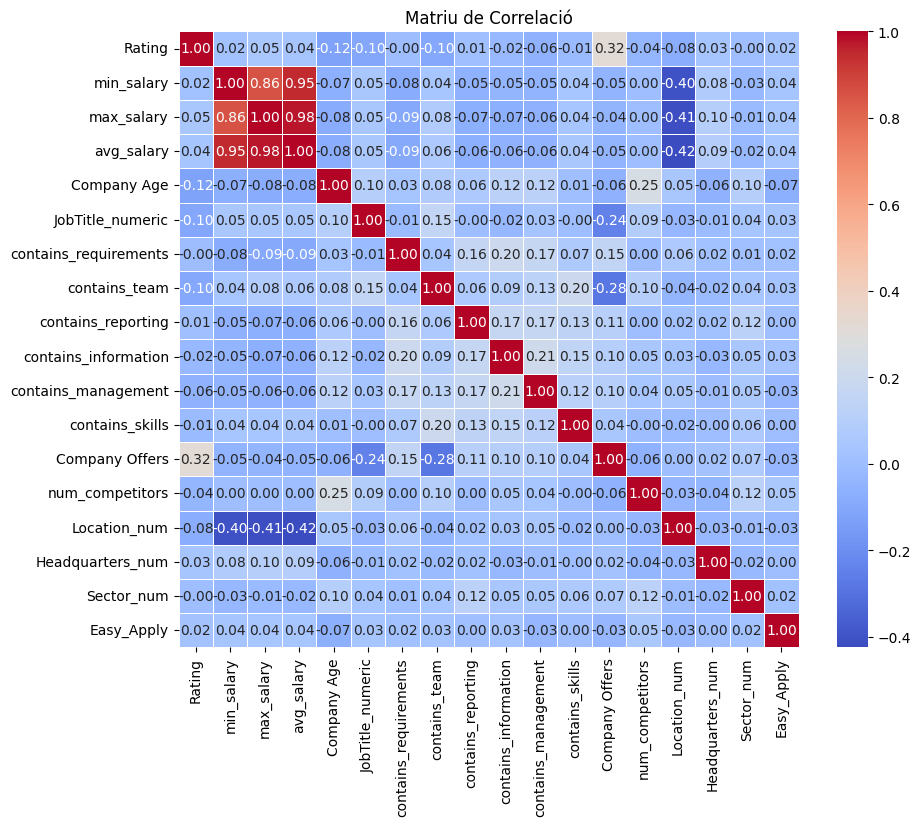

In [82]:
correlation_matrix = final_model.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matriu de Correlació')
plt.show()


In [83]:
final_model.to_csv("data_preprocessed.csv", index=False)
